In [1]:
# Alberto Bejarano (2025)
# 02_openFDA_UMAP_v01
# pip install nbqa flake8
# nbqa flake8 openFDA_UMAP_v06.ipynb --select=F401

In [2]:
# These Jupyter notebooks process FDA adverse event data for a set of drugs. It first retrieves data using an API and extracts relevant details about the types of adverse events
# for each drug. The data is then aggregated, grouped by drug and event, and pivoted into a table format for further analysis. The notebook applies data scaling and dimensionality
# reduction techniques, such as Principal Component Analysis (PCA), to standardize and reduce the dimensionality of the dataset. It uses clustering (Leiden algorithm) to group 
# similar data points and explores the relationships between the drugs and their adverse events. Finally, the notebook visualizes the results using UMAP, providing insights into 
# the patterns and associations between the drugs and the severity of their associated adverse events.

In [3]:
# 02_openFDA_UMAP_v01
# This notebook analyzes FDA adverse event (AE) data for both standard-of-care (SoC) and investigational drugs, with a focus on serious events such as LifeThreatening cases. 
# It retrieves, merges, and reshapes the data into a structured drug-by-event matrix, scales the values, and reduces dimensionality using PCA. 
# The Leiden algorithm is applied across multiple resolutions to detect clusters of drugs with similar AE profiles. UMAP is then computed using different `min_dist` and `spread` 
# values to visualize these clusters in 2D space. The results help identify AE-driven groupings of drugs and visualize how their safety profiles relate to each other.

In [4]:
#import os   # Record the name of the active Conda environment
#env_name = os.getenv('CONDA_DEFAULT_ENV'); print(f"Active Conda environment: {env_name}")
#!conda env export > {env_name}.yml

In [5]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

April 21, 2025 19:05:35


In [6]:
import warnings
from anndata._core.aligned_df import ImplicitModificationWarning
warnings.simplefilter("ignore", ImplicitModificationWarning)

In [7]:
import scanpy as sc; sc.settings.seed = 42

In [8]:
import requests, time, matplotlib, contextlib, os
from IPython.display import Audio, display
#         .         .         .         .         .         .         .         .
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
from itertools import cycle
import seaborn as sns
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns  = 200
import numpy as np

In [9]:
# 'Death', 'Hospitalization', 'LifeThreatening',' Other', 'Total', '%Death', '%Hospitalization', '%LifeThreatening',' %Other', '%Total']]
seriousness = 'LifeThreatening'

In [10]:
resolutions = [0, 1, 2, 3, 4]
#resolutions = list(range(0, 22, 1))
#resolutions = np.round(np.arange(0, 5, 0.1), 2).tolist()

In [11]:
resolution   = 2          # Running PCA and Leiden
n_iterations = -1

In [12]:
SoC_AEs_df = pd.read_csv("./data/standard_of_care.csv")
SoC_AEs_df["data_source"]  = "SoC_AEs"
SoC_AEs_df.sample(3)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total,data_source
36314,Letrozole,Tongue Erythema,2,4,2,2,10,0.03,0.03,0.04,0.01,0.02,SoC_AEs
10508,Exemestane,Cardiac Disorder,12,17,10,17,56,0.03,0.03,0.02,0.03,0.03,SoC_AEs
109333,Cabozantinib,Dyschezia,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,SoC_AEs


In [13]:
drug_AEs_df = pd.read_csv("./data/drug_AEs.csv")
drug_AEs_df["data_source"] = "drug_AEs"
drug_AEs_df.sample(3)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total,data_source
4593,Adcetris,Small Intestinal Obstruction,0,1,0,5,6,0.00,0.01,0.00,0.04,0.01,drug_AEs
5828,Kadcyla,Glomerular Filtration Rate Increased,0,1,0,1,2,0.00,0.01,0.00,0.00,0.00,drug_AEs
1332,Enhertu,Ventricular Dysfunction,10,8,10,7,35,0.04,0.03,0.04,0.03,0.04,drug_AEs


In [14]:
df_concat = pd.concat([SoC_AEs_df, drug_AEs_df], ignore_index=True)
df_concat.sample(3)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total,data_source
59288,Capecitabine,Prothrombin Level Increased,1,1,2,1,5,0.01,0.01,0.05,0.00,0.01,SoC_AEs
30678,Atezolizumab,Exercise Tolerance Decreased,4,4,4,2,14,0.02,0.02,0.02,0.01,0.02,SoC_AEs
104838,Irinotecan,Eyelash Changes,0,0,0,1,1,0.00,0.00,0.00,0.00,0.00,SoC_AEs


In [15]:
drug_names_list = df_concat['Drug_Name'].unique().tolist()
drug_names_word_list =  ", ".join(sorted(drug_names_list));  
print("\n",len(drug_names_list))
print('\n\033[32m', drug_names_word_list, '\033[0m\n')


 52

 5-Fu, Abemaciclib, Abiraterone, Adcetris, Alectinib, Anastrozole, Apalutamide, Atezolizumab, Bevacizumab, Cabazitaxel, Cabozantinib, Capecitabine, Carboplatin, Cetuximab, Cisplatin, Dabrafenib, Docetaxel, Durvalumab, Enfortumab Vedotin, Enhertu, Enzalutamide, Etoposide, Exemestane, Fulvestrant, Gemcitabine, Goserelin, Irinotecan, Kadcyla, Lenvatinib, Letrozole, Leucovorin, Levothyroxine, Lorlatinib, Nivolumab, Osimertinib, Paclitaxel, Palbociclib, Panitumumab, Pembrolizumab, Pertuzumab, Polivy, Regorafenib, Ribociclib, Sorafenib, T-Dm1, T-Dxd, Tamoxifen, Trametinib, Trastuzumab, Tremelimumab, Trodelvy, Vandetanib 



In [16]:
df_concat_2 = df_concat[['data_source', 'Drug_Name', 'Adverse_Event', 'Death', 'Hospitalization', 'LifeThreatening', 'Other', 'Total',
                         '%Death', '%Hospitalization', '%LifeThreatening', '%Other', '%Total']]
df_concat_2.head(3)

,data_source,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total
0,SoC_AEs,Pertuzumab,Diarrhoea,1750,1828,1820,1753,7151,4.06,4.05,4.01,4.03,4.04
1,SoC_AEs,Pertuzumab,Off Label Use,1648,1603,1833,1404,6488,3.82,3.55,4.03,3.23,3.66
2,SoC_AEs,Palbociclib,Neutropenia,1562,1530,1499,1710,6301,3.55,3.39,3.37,4.16,3.61


In [17]:
pivot_df = df_concat_2.pivot_table(index=['data_source', 'Drug_Name'], columns='Adverse_Event', values=seriousness, aggfunc='sum', fill_value=0)
pivot_df = pivot_df.reset_index()
pivot_df.index.name = None
pivot_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_df.columns]
print(len(pivot_df)); pivot_df.head(3)

53


,data_source,Drug_Name,5-Hydroxyindolacetic Acid In Urine,5-Hydroxyindolacetic Acid Increased,5Q Minus Syndrome,Abasia,Abdomen Crushing,Abdominal Abscess,Abdominal Adhesions,Abdominal Bruit,Abdominal Cavity Drainage,Abdominal Compartment Syndrome,Abdominal Discomfort,Abdominal Distension,Abdominal Fat Apron,Abdominal Hernia,Abdominal Hernia Perforation,Abdominal Hernia Repair,Abdominal Incarcerated Hernia,Abdominal Infection,Abdominal Injury,Abdominal Lymphadenopathy,Abdominal Mass,Abdominal Neoplasm,Abdominal Operation,Abdominal Pain,Abdominal Pain Lower,Abdominal Pain Upper,Abdominal Rebound Tenderness,Abdominal Rigidity,Abdominal Sepsis,Abdominal Strangulated Hernia,Abdominal Symptom,Abdominal Tenderness,Abdominal Wall Abscess,Abdominal Wall Cyst,Abdominal Wall Disorder,Abdominal Wall Haematoma,Abdominal Wall Haemorrhage,Abdominal Wall Infection,Abdominal Wall Mass,Abdominal Wall Neoplasm Malignant,Abdominal Wall Oedema,Abdominal Wall Pain,Abdominal Wall Sinus,Abdominal Wall Wound,Abdominal Wound Dehiscence,Aberrant Aortic Arch,Abnormal Behaviour,Abnormal Clotting Factor,Abnormal Dreams,Abnormal Faeces,Abnormal Labour,Abnormal Loss Of Weight,Abnormal Menstrual Clots,Abnormal Sensation In Eye,Abnormal Sleep-Related Event,Abnormal Uterine Bleeding,Abnormal Weight Gain,Abnormal Withdrawal Bleeding,Abortion,Abortion Incomplete,Abortion Induced,Abortion Induced Complete,Abortion Missed,Abortion Spontaneous,Abortion Spontaneous Incomplete,Abscess,Abscess Bacterial,Abscess Drainage,Abscess Fungal,Abscess Intestinal,Abscess Jaw,Abscess Limb,Abscess Neck,Abscess Oral,Abscess Rupture,Abscess Soft Tissue,Abscess Sterile,Absent Bowel Movement,Abulia,Acalculia,Acanthamoeba Infection,Acantholysis,Acanthosis,Acanthosis Nigricans,Acarodermatitis,Accelerated Hypertension,Accelerated Idioventricular Rhythm,Accessory Spleen,Accident,Accident At Home,Accident At Work,Accidental Death,Accidental Exposure To Product,Accidental Exposure To Product By Child,Accidental Exposure To Product Packaging,Accidental Exposure To Product Packaging By Child,Accidental Overdose,Accidental Poisoning,...,Vulvovaginal Pruritus,Vulvovaginal Rash,Vulvovaginal Swelling,Vulvovaginitis,Waist Circumference Decreased,Waist Circumference Increased,Waldenstrom^S Macroglobulinaemia,Walking Aid User,Walking Disability,Walking Distance Test Abnormal,Wall Motion Score Index Abnormal,Walled-Off Pancreatic Necrosis,Wallerian Degeneration,Warm Type Haemolytic Anaemia,Water Intoxication,Weaning Failure,Weight Abnormal,Weight Bearing Difficulty,Weight Control,Weight Decreased,Weight Fluctuation,Weight Gain Poor,Weight Increased,Weight Loss Poor,Welander Distal Myopathy,Werner^S Syndrome,Wernicke^S Encephalopathy,West Nile Viral Infection,West Nile Virus Test Positive,Wheelchair User,Wheezing,White Blood Cell Analysis Abnormal,White Blood Cell Analysis Decreased,White Blood Cell Count,White Blood Cell Count Abnormal,White Blood Cell Count Decreased,White Blood Cell Count Increased,White Blood Cell Disorder,White Blood Cells Urine,White Blood Cells Urine Positive,White Coat Hypertension,White Matter Lesion,Wisdom Teeth Removal,Withdrawal Hypertension,Withdrawal Of Life Support,Withdrawal Syndrome,Wolff-Parkinson-White Syndrome,Wound,Wound Abscess,Wound Complication,Wound Decomposition,Wound Dehiscence,Wound Drainage,Wound Evisceration,Wound Haematoma,Wound Haemorrhage,Wound Infection,Wound Infection Bacterial,Wound Infection Fungal,Wound Infection Pseudomonas,Wound Infection Staphylococcal,Wound Necrosis,Wound Secretion,Wound Sepsis,Wound Treatment,Wrist Deformity,Wrist Fracture,Wrist Surgery,Wrong Device Used,Wrong Dosage Form,Wrong Dosage Formulation,Wrong Dose,Wrong Drug Administered,Wrong Patient,Wrong Patient Received Medication,Wrong Patient Received Product,Wrong Product Administered,Wrong Schedule,Wrong Strength,Wrong Technique In Device Usage Process,Wrong Technique In Drug Usage Process,Wrong Technique In Product Usage Process,X-Linked Chromosomal Disorder,X-Ray,X-Ray Abn

In [18]:
# Drop 'Drug_Name' for scaling and keep it for later
drug_names = pivot_df[['data_source', 'Drug_Name']]
drug_names.sample(3)

,data_source,Drug_Name
38,SoC_AEs,Regorafenib
34,SoC_AEs,Palbociclib
24,SoC_AEs,Irinotecan


In [19]:
pivot_df2 = pivot_df.drop(columns=['data_source', 'Drug_Name'])
print(len(pivot_df2)); pivot_df2.head(3)

53


,5-Hydroxyindolacetic Acid In Urine,5-Hydroxyindolacetic Acid Increased,5Q Minus Syndrome,Abasia,Abdomen Crushing,Abdominal Abscess,Abdominal Adhesions,Abdominal Bruit,Abdominal Cavity Drainage,Abdominal Compartment Syndrome,Abdominal Discomfort,Abdominal Distension,Abdominal Fat Apron,Abdominal Hernia,Abdominal Hernia Perforation,Abdominal Hernia Repair,Abdominal Incarcerated Hernia,Abdominal Infection,Abdominal Injury,Abdominal Lymphadenopathy,Abdominal Mass,Abdominal Neoplasm,Abdominal Operation,Abdominal Pain,Abdominal Pain Lower,Abdominal Pain Upper,Abdominal Rebound Tenderness,Abdominal Rigidity,Abdominal Sepsis,Abdominal Strangulated Hernia,Abdominal Symptom,Abdominal Tenderness,Abdominal Wall Abscess,Abdominal Wall Cyst,Abdominal Wall Disorder,Abdominal Wall Haematoma,Abdominal Wall Haemorrhage,Abdominal Wall Infection,Abdominal Wall Mass,Abdominal Wall Neoplasm Malignant,Abdominal Wall Oedema,Abdominal Wall Pain,Abdominal Wall Sinus,Abdominal Wall Wound,Abdominal Wound Dehiscence,Aberrant Aortic Arch,Abnormal Behaviour,Abnormal Clotting Factor,Abnormal Dreams,Abnormal Faeces,Abnormal Labour,Abnormal Loss Of Weight,Abnormal Menstrual Clots,Abnormal Sensation In Eye,Abnormal Sleep-Related Event,Abnormal Uterine Bleeding,Abnormal Weight Gain,Abnormal Withdrawal Bleeding,Abortion,Abortion Incomplete,Abortion Induced,Abortion Induced Complete,Abortion Missed,Abortion Spontaneous,Abortion Spontaneous Incomplete,Abscess,Abscess Bacterial,Abscess Drainage,Abscess Fungal,Abscess Intestinal,Abscess Jaw,Abscess Limb,Abscess Neck,Abscess Oral,Abscess Rupture,Abscess Soft Tissue,Abscess Sterile,Absent Bowel Movement,Abulia,Acalculia,Acanthamoeba Infection,Acantholysis,Acanthosis,Acanthosis Nigricans,Acarodermatitis,Accelerated Hypertension,Accelerated Idioventricular Rhythm,Accessory Spleen,Accident,Accident At Home,Accident At Work,Accidental Death,Accidental Exposure To Product,Accidental Exposure To Product By Child,Accidental Exposure To Product Packaging,Accidental Exposure To Product Packaging By Child,Accidental Overdose,Accidental Poisoning,Accidental Underdose,Accommodation Disorder,...,Vulvovaginal Pruritus,Vulvovaginal Rash,Vulvovaginal Swelling,Vulvovaginitis,Waist Circumference Decreased,Waist Circumference Increased,Waldenstrom^S Macroglobulinaemia,Walking Aid User,Walking Disability,Walking Distance Test Abnormal,Wall Motion Score Index Abnormal,Walled-Off Pancreatic Necrosis,Wallerian Degeneration,Warm Type Haemolytic Anaemia,Water Intoxication,Weaning Failure,Weight Abnormal,Weight Bearing Difficulty,Weight Control,Weight Decreased,Weight Fluctuation,Weight Gain Poor,Weight Increased,Weight Loss Poor,Welander Distal Myopathy,Werner^S Syndrome,Wernicke^S Encephalopathy,West Nile Viral Infection,West Nile Virus Test Positive,Wheelchair User,Wheezing,White Blood Cell Analysis Abnormal,White Blood Cell Analysis Decreased,White Blood Cell Count,White Blood Cell Count Abnormal,White Blood Cell Count Decreased,White Blood Cell Count Increased,White Blood Cell Disorder,White Blood Cells Urine,White Blood Cells Urine Positive,White Coat Hypertension,White Matter Lesion,Wisdom Teeth Removal,Withdrawal Hypertension,Withdrawal Of Life Support,Withdrawal Syndrome,Wolff-Parkinson-White Syndrome,Wound,Wound Abscess,Wound Complication,Wound Decomposition,Wound Dehiscence,Wound Drainage,Wound Evisceration,Wound Haematoma,Wound Haemorrhage,Wound Infection,Wound Infection Bacterial,Wound Infection Fungal,Wound Infection Pseudomonas,Wound Infection Staphylococcal,Wound Necrosis,Wound Secretion,Wound Sepsis,Wound Treatment,Wrist Deformity,Wrist Fracture,Wrist Surgery,Wrong Device Used,Wrong Dosage Form,Wrong Dosage Formulation,Wrong Dose,Wrong Drug Administered,Wrong Patient,Wrong Patient Received Medication,Wrong Patient Received Product,Wrong Product Administered,Wrong Schedule,Wrong Strength,Wrong Technique In Device Usage Process,Wrong Technique In Drug Usage Process,Wrong Technique In Product Usage Process,X-Linked Chromosomal Di

In [20]:
# Keep a numeric-only version
df_numeric       = pivot_df2.select_dtypes(include='number').copy()
df_numeric       = df_numeric.apply(pd.to_numeric, errors='coerce', downcast='float')
pivot_df.index   = pivot_df2.index.astype(str)
df_numeric.index = df_numeric.index.astype(str)
print(df_numeric.shape); print(df_numeric.max().max())

(53, 11286)
1833.0


In [21]:
%%time
#         .         .         .         .         .         .         .         .
min_dist = 1E3
spread   = 1E2     
#         .         .         .         .         .         .         .         .
resolution_cluster_counts = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        from anndata._core.aligned_df import ImplicitModificationWarning
        warnings.simplefilter("ignore", ImplicitModificationWarning)

        # Prepare the data
        df_numeric = pivot_df2.select_dtypes(include='number').copy()  # Flatten MultiIndex if present and reset index
        if isinstance(df_numeric.index, pd.MultiIndex):
            df_numeric = df_numeric.reset_index(drop=True)

        pivot_df = pivot_df.reset_index(drop=True)  # Reset index on pivot_df to ensure alignment

        # Create AnnData object
        adata_temp = sc.AnnData(df_numeric)
        adata_temp.obs['Drug_Name'] = pivot_df['Drug_Name'].values
        adata_temp.obs['data_source'] = pivot_df['data_source'].values
        
        sc.pp.pca(adata_temp)  # Perform PCA
        sc.pp.neighbors(adata_temp)  # Calculate nearest neighbors
        
        # Iterate over each resolution and compute Leiden clustering
        for res in tqdm(resolutions):
            leiden_key = f'Leiden_{res}'  # Create a key for each resolution
            print(f"Running Leiden for resolution: {res}")
            
            # Perform Leiden clustering
            sc.tl.leiden(adata_temp, random_state=42, resolution=res, key_added=leiden_key, 
                         flavor="igraph", n_iterations=n_iterations, directed=False)
            
            # Store the clustering result in the dataframe
            df = adata_temp.obs[[leiden_key]].copy()
            df['resolution'] = res  # Add resolution column
            
            # Count the number of unique clusters
            num_clusters = df[leiden_key].nunique()
            resolution_cluster_counts.append([res, num_clusters])

        # Recompute UMAP with the final parameters
        with warnings.catch_warnings():  # Suppress warnings for UMAP computation
            warnings.simplefilter("ignore")
            with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
                sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)

# Convert the resolution and number of clusters into a DataFrame
df_resolutions_clusters = pd.DataFrame(resolution_cluster_counts, columns=["resolution", "number_of_clusters"])

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 30.9 s
Wall time: 31.3 s


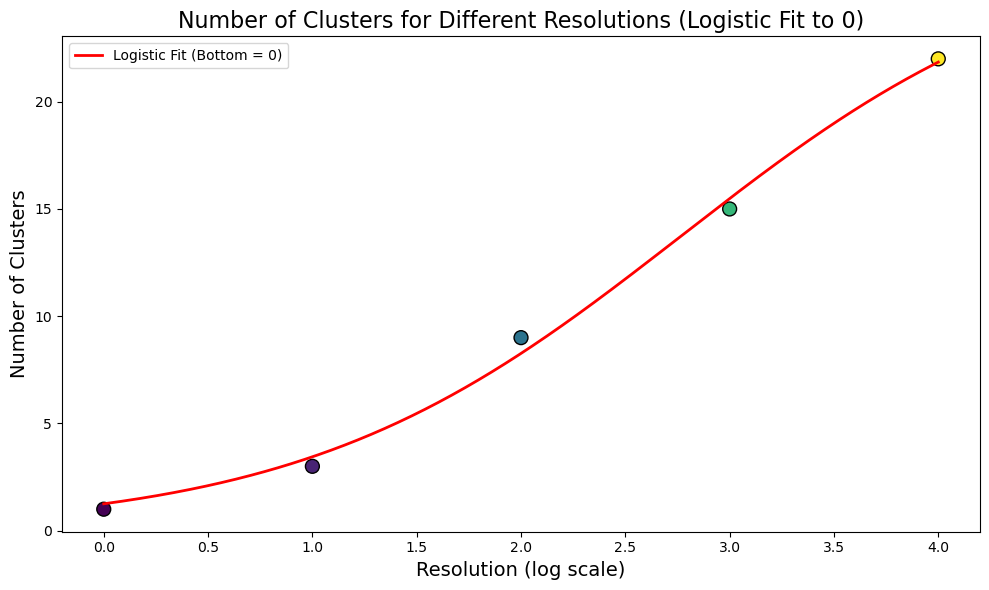

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Logistic function with bottom forced to y = 0
def logistic_zero_base(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Extract x and y
x_data = df_resolutions_clusters['resolution'].values
y_data = df_resolutions_clusters['number_of_clusters'].values

# Initial guess: [maximum value, midpoint, slope]
initial_guess = [max(y_data), np.median(x_data), 1]

# Fit the logistic model
params, _ = curve_fit(logistic_zero_base, x_data, y_data, p0=initial_guess)

# Generate smooth curve
x_curve = np.linspace(min(x_data), max(x_data), 500)
y_curve = logistic_zero_base(x_curve, *params)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x_data, y_data, c=y_data, cmap='viridis', s=100, edgecolor='black')
ax.plot(x_curve, y_curve, color='red', linewidth=2, label="Logistic Fit (Bottom = 0)")

#ax.set_xscale('log'); ax.set_yscale('log'); 
ax.set_title("Number of Clusters for Different Resolutions (Logistic Fit to 0)", fontsize=16)
ax.set_xlabel("Resolution (log scale)", fontsize=14)
ax.set_ylabel("Number of Clusters", fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()


In [23]:
adata_temp

AnnData object with n_obs × n_vars = 53 × 11286
    obs: 'Drug_Name', 'data_source', 'Leiden_0', 'Leiden_1', 'Leiden_2', 'Leiden_3', 'Leiden_4'
    uns: 'pca', 'neighbors', 'Leiden_0', 'Leiden_1', 'Leiden_2', 'Leiden_3', 'Leiden_4', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [24]:
# Get UMAP coordinates and labels
umap_coords  = adata_temp.obsm["X_umap"]
drug_names   = adata_temp.obs["Drug_Name"]
data_sources = adata_temp.obs["data_source"]

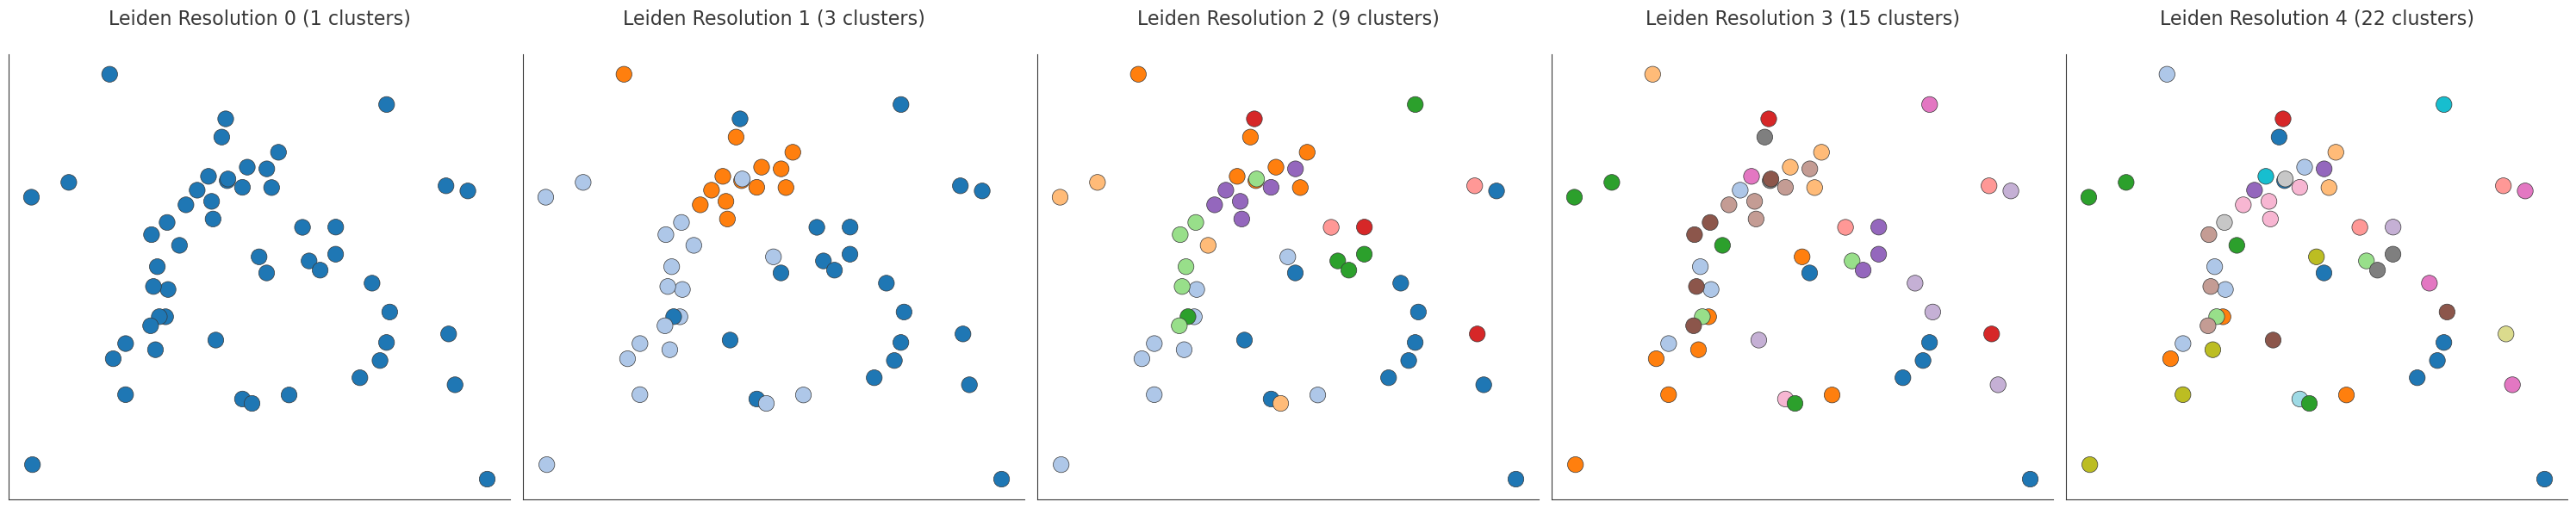

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(30, 6))  # 5 plots in a row
plt.subplots_adjust(wspace=0.4)

scatter_kws = { "s": 175, "edgecolor": "#383838", "linewidth": 0.5, "zorder": 2 }
title_kws   = { "color": "#383838", "fontsize": 16, "pad": 25 }


for ax, res in zip(axs, resolutions):
    leiden_key = f'Leiden_{res}'
    unique_clusters = adata_temp.obs[leiden_key].unique(); num_clusters = len(unique_clusters)
    
    cmap = matplotlib.colormaps.get_cmap("tab20")
    color_dict = {name: cmap(i % cmap.N) for i, name in enumerate(unique_clusters)}
    colors = [color_dict[name] for name in adata_temp.obs[leiden_key]]

    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=colors, **scatter_kws)
    ax.set_title(f"Leiden Resolution {res} ({num_clusters} clusters)", **title_kws)

    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel(''); ax.set_ylabel('')
    ax.spines['top'].set_visible(False);   ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#383838'); ax.spines['bottom'].set_color('#383838')

    # Add legend for each resolution plot
    legend_kws = { "fontsize": 8, "title": "", "labelspacing": 0.2, "handleheight": 0.8, "handlelength": 1.2,
                   "loc": "lower left", "bbox_to_anchor": (0.20, 0), "frameon": False }
    
    legend_handles = [Patch(color=color, label=label) for label, color in color_dict.items()]
    #ax.legend(handles=legend_handles, **legend_kws)  # Add the legend directly to each subplot

# Remove additional ticks and labels for all subplots
for ax in axs:
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#383838'); ax.spines['bottom'].set_color('#383838')

plt.tight_layout()
#plt.savefig(f"./plots/UMAP_5_Leiden_Resolutions.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [26]:
# Path to your audio file
audio_file = "./data/clock-chime-88027.mp3"
display(Audio(audio_file, autoplay=True))

In [27]:
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print("'02_openFDA_UMAP_v01' script run time:", f"{int(minutes)} min {int(seconds)} sec.")

'02_openFDA_UMAP_v01' script run time: 0 min 48 sec.
